In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    torchvision.transforms.Grayscale(num_output_channels=1)#0-255 to 0-1, numpy to tensors
])

In [5]:
#dataloader
train_path = r"C:\Dataset\Train_set"
test_path = r"C:\Dataset\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=72, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=36, shuffle=True
)

In [6]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']


In [7]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=23):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=8)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu4=nn.ReLU()
        #Shape= (256,20,75,75)
        
        self.conv5=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn5=nn.BatchNorm2d(num_features=128)
        #Shape= (256,32,75,75)
        self.relu5=nn.ReLU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=150 * 150 * 128,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
        
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
        
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,128*150*150)
            
            
        output=self.fc(output)
            
        return output
            

In [8]:
model=ConvNet(num_classes=23).to(device)

In [9]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [10]:
num_epochs=30

In [11]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [12]:
print(train_count,test_count)

77846 23666


Epoch: 0 Train Loss: tensor(27.3720) Train Accuracy: 0.2618631657374817 Test Accuracy: 0.3320797768951238
Epoch: 1 Train Loss: tensor(1.0480) Train Accuracy: 0.7296585566374637 Test Accuracy: 0.3712076396518212
Epoch: 2 Train Loss: tensor(0.5793) Train Accuracy: 0.8512447653058602 Test Accuracy: 0.4132088227837404
Epoch: 3 Train Loss: tensor(0.4078) Train Accuracy: 0.8972329984841867 Test Accuracy: 0.4686047494295614
Epoch: 4 Train Loss: tensor(0.3230) Train Accuracy: 0.9195976671890655 Test Accuracy: 0.583030507901631
Epoch: 5 Train Loss: tensor(0.2939) Train Accuracy: 0.924299257508414 Test Accuracy: 0.5951998647849235
Epoch: 6 Train Loss: tensor(0.2516) Train Accuracy: 0.9345631117848059 Test Accuracy: 0.5884391109608721
Epoch: 7 Train Loss: tensor(0.2293) Train Accuracy: 0.9409732035043548 Test Accuracy: 0.5170709034057297
Epoch: 8 Train Loss: tensor(0.2065) Train Accuracy: 0.9457904067004085 Test Accuracy: 0.5845939322234429
Epoch: 9 Train Loss: tensor(0.1777) Train Accuracy: 0.95

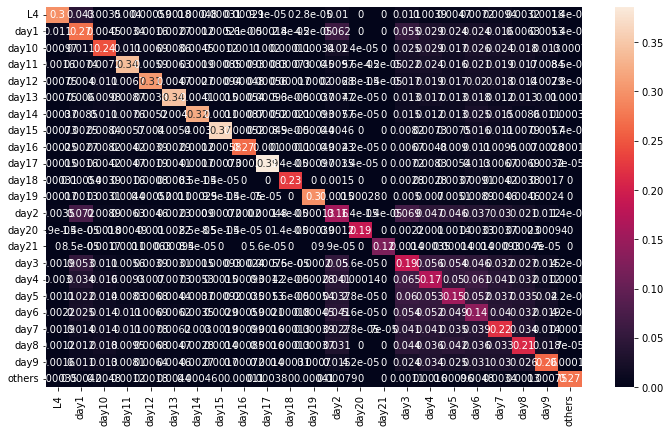

In [13]:
#Model training and saving best model
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = []
y_true = []
trainarr=[]
testarr=[]

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    trainarr.append(train_loss)
    testarr.append(test_accuracy) 
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_CNN_DayWise.model')
        best_accuracy=test_accuracy
        
 # constant for classes
classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
#tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

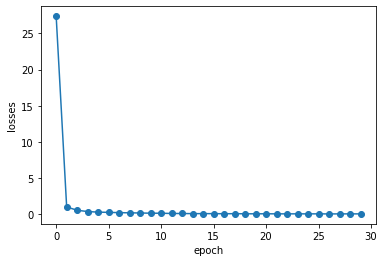

In [15]:
plt.figure()
plt.plot(trainarr,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
 
plt.show()

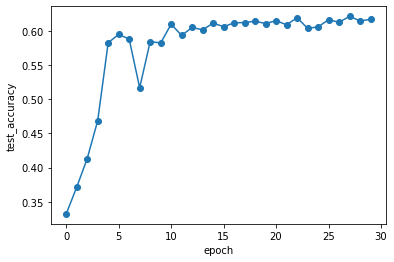

In [16]:
plt.plot(testarr,'-o')
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
 
plt.show()